# Modelo con embeddings

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

D:\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Ateísmo vs autos

In [172]:
ng_ateauto = pd.read_pickle('20newsgroups_ateauto_embd_all.pkl')

ng_ateauto.head()

,id_documento,Grupo,Documento,Target,Embedding
14,53347,alt.atheism,notion heliocentric galacticentric -----------...,0,"[0.31788067147135735, -0.19147165988882384, -0..."
20,103698,rec.autos,buy chevy gmc size pickup extended cab opinion...,7,"[0.030914567030966282, 0.26029603904113174, -0..."
29,54189,alt.atheism,relativist answer question phrase question una...,0,"[-0.1474168705853059, 0.1291574453340566, -0.1..."
30,103781,rec.autos,write resource consumer compare model automobi...,7,"[-0.1360333832670693, 0.24755564579498712, 0.0..."
43,102769,rec.autos,archive rec autospart automotive articles arch...,7,"[0.06553854725577614, -0.08145841294687918, 0...."


In [173]:
ng_ateauto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1705 entries, 14 to 18265
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  1705 non-null   int64 
 1   Grupo         1705 non-null   object
 2   Documento     1705 non-null   object
 3   Target        1705 non-null   int64 
 4   Embedding     1705 non-null   object
dtypes: int64(2), object(3)
memory usage: 79.9+ KB


In [174]:
ng_ateauto['Target'] = ng_ateauto['Target'].replace({7:1})

Definimos una función que genera el modelo y lo evalúa con cross_validation

**DESCRIBIR BIEN**

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
, classification_report


def metricas(y_val, y_pred):
    
# Calcular Accuracy (Precisión)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

# Calcular Precision (Precisión)
    precision = precision_score(y_val, y_pred, average='macro')  # 'macro' para clasificación multiclase
    print(f'Precision: {precision:.4f}')

# Calcular Recall (Recuperación)
    recall = recall_score(y_val, y_pred, average='macro')  # 'macro' para clasificación multiclase
    print(f'Recall: {recall:.4f}')

# Calcular F1-Score
    f1 = f1_score(y_val, y_pred, average='macro')  # 'macro' para clasificación multiclase
    print(f'F1-Score: {f1:.4f}')
    
# Matriz de Confusión
#     conf_matrix = confusion_matrix(y_val, y_pred)
#     print('Matriz de Confusión:')
#     print(conf_matrix)
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Reporte de Clasificación
    class_report = classification_report(y_val, y_pred)
    print('Reporte de Clasificación:')
    print(class_report)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

class red:
    def __init__(self, hidden_units, output_units, activation, epochs, batch_size, callbacks):
        self.hidden_units = hidden_units
        self.output_units = output_units
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.callbacks = callbacks
        self.model = self._build_model()

    def _build_model(self):
        
        if type(self.hidden_units) == int:
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(self.hidden_units, activation='relu', input_shape=(300,)),
                tf.keras.layers.Dense(self.output_units, activation=self.activation)
            ])
        else:
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(self.hidden_units[0], activation='relu', input_shape=(300,)),
                tf.keras.layers.Dense(self.hidden_units[1], activation='relu'),
                tf.keras.layers.Dense(self.output_units, activation=self.activation)
            ])
            
        return model

    def compilar(self, f_perdida, optimizer='adam', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=f_perdida, metrics=metrics)

    def entrenar(self, x_train, y_train, validation_data):
        self.model.fit(x_train, y_train, validation_data=validation_data, epochs=self.epochs, batch_size=self.batch_size, verbose=0, callbacks=self.callbacks)

    def evaluar(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)
    
    def predecir(self, x_test):
        return self.model.predict(x_test)
    
    def reentrenar(self, x_train, y_train):
        self.model.fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0, callbacks=self.callbacks)


In [16]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

def modelaje_n(X, y, hidden_units = [128, 64], epochs=100, batch_size=128, parar=True, show=False):
    
    if type(y[0])==np.int64:
        n = 1
        f_perdida = 'binary_crossentropy'
        activacion = 'sigmoid'
    else:
        n = len(y[0])
        f_perdida = 'categorical_crossentropy'
        activacion = 'softmax'
        
    
    X_tensor = np.asarray([tf.constant(arr) for arr in X])
    y_tensor = np.asarray([tf.constant(arr) for arr in y])
    
    parada = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) if parar else 'None'
    
    kfold = KFold(n_splits=4, shuffle=True, random_state=2808)

    accuracies = []
    
    
    for train_index, val_index in kfold.split(X_tensor):
        X_train, X_val = X_tensor[train_index], X_tensor[val_index]
        y_train, y_val = y_tensor[train_index], y_tensor[val_index]

        modelo = red(hidden_units = hidden_units, output_units=n, activation=activacion, epochs=epochs, batch_size=batch_size, callbacks=[parada])
        modelo.compilar(f_perdida=f_perdida)
        modelo.entrenar(X_train, y_train, validation_data=(X_val, y_val))

        loss, accuracy = modelo.evaluar(X_val, y_val)
        accuracies.append(accuracy) 
    
    if show:
        preds = modelo.predecir(X_val)
        
        if n == 1:
            cm = confusion_matrix(y_val, np.round(preds))
        else:
            cm = confusion_matrix([np.argmax(target) for target in y_val], [np.argmax(pred) for pred in preds])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
        plt.xlabel('Predicho')
        plt.ylabel('Verdadero')
        plt.title('Matriz de confusión')
        plt.show()
        
    #modelo.entrenar(X_tensor, y_tensor, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[parada])
    
    return(modelo, np.mean(accuracies))

In [5]:
def grid_search(X, y, hidden_units = [[128, 64]], epochs=100, batch_sizes=128):
    
    resultados ={}
    modelo_final = None
    accuracy_final = 0
    
    for hidden_unit in hidden_units:
        for epoch in epochs:
            for batch_size in batch_sizes:
                print(f'Modelo con {hidden_unit}, {epoch}, {batch_size}')
                modelo, accuracy = modelaje_n(X, y, hidden_unit, epoch, batch_size)
                print(accuracy*100)
                if accuracy > accuracy_final:
                    modelo_final = modelo
                if isinstance(hidden_unit, list):
                    resultados[(tuple(hidden_unit), epoch, batch_size)] = accuracy
                else:
                    resultados[(hidden_unit, epoch, batch_size)] = accuracy
                
                
    return modelo_final, resultados

In [25]:
from sklearn.metrics import accuracy_score

def comprobar(y_val, y_pred):
   
    if type(y_val[0])==np.int64:
        y_pred = np.round(y_pred)
    else:
        y_val = [np.argmax(target) for target in y_val]
        y_pred = [np.argmax(pred) for pred in y_pred]
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.title('Matriz de confusión')
    plt.show()
    
    return accuracy_score(y_val, y_pred) 

In [175]:
X, y = ng_ateauto['Embedding'].values, ng_ateauto['Target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [177]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_ateauto, resultados = grid_search(X_train, y_train, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
11/11 [==============================] - 0s 3ms/step - loss: 0.1402 - accuracy: 0.9413
94.57477927207947
Modelo con [64, 10], 80, 200
11/11 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9355
94.428151845932
Modelo con [64, 10], 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.1382 - accuracy: 0.9296
94.13489699363708
Modelo con [64, 10], 150, 200
11/11 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9443
94.6480929851532
Modelo con 100, 80, 100
11/11 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.9326
94.28152441978455
Modelo con 100, 80, 200
11/11 [==============================] - 0s 1ms/step - loss: 0.1311 - accuracy: 0.9384
94.6480929851532
Modelo con 100, 150, 100
11/11 [==============================] - 0s 2ms/step - loss: 0.1388 - accuracy: 0.9384
94.428151845932
Modelo con 100, 150, 200
11/11 [==============================] - 0s 2ms/step - 

In [178]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{((80, 20), 80, 100): 0.9486803412437439,
 ((64, 10), 150, 200): 0.946480929851532,
 (100, 80, 200): 0.946480929851532,
 ((80, 20), 150, 200): 0.946480929851532,
 ((64, 10), 80, 100): 0.9457477927207947,
 ((80, 20), 150, 100): 0.9457477927207947,
 ((64, 10), 80, 200): 0.9442815184593201,
 (100, 150, 100): 0.9442815184593201,
 ((80, 20), 80, 200): 0.9435483813285828,
 (100, 80, 100): 0.9428152441978455,
 ((64, 10), 150, 100): 0.9413489699363708,
 (100, 150, 200): 0.9413489699363708}

Nos quedamos con el modelo de [64,10], 80, 100

In [185]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_ateauto.model.fit(X_tensor, y_tensor)

43/43 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9736


In [186]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_ateauto.predecir(X_val_tensor)

11/11 [==============================] - 0s 2ms/step


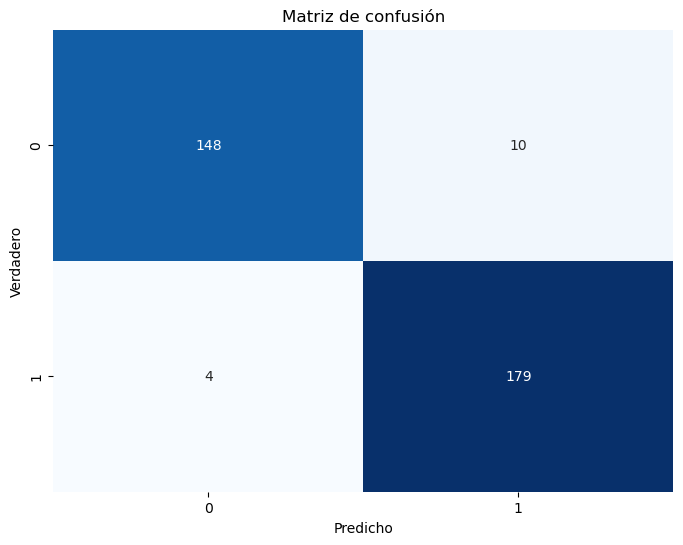

0.9589442815249267

In [187]:
acc_ateauto = comprobar(y_val, preds)
acc_ateauto

## A4

In [8]:
ng_a4 = pd.read_pickle('20newsgroups_a4_embd_all.pkl')

ng_a4.head()

,id_documento,Grupo,Documento,Target,Embedding
13,59022,sci.med,kirlian imaging faq sciskeptic nice write supp...,13,"[-0.02201554331589829, 0.2004741860384291, 0.0..."
20,103698,rec.autos,buy chevy gmc size pickup extended cab opinion...,7,"[0.030914567030966282, 0.26029603904113174, -0..."
22,38296,comp.graphics,imagine real amiga user real amiga imagine ami...,1,"[-0.015612084180750746, 0.010558662978199093, ..."
26,54726,talk.politics.guns,report canadian paper thursday april source up...,16,"[-0.274964645613936, 0.14791480858037445, -0.0..."
27,38295,comp.graphics,vmode command type vmode vesa dos prompt vmode...,1,"[0.22213156139478088, -0.13350700164834658, 0...."


In [9]:
set(ng_a4['Target'])

{1, 7, 13, 16}

In [10]:
ng_a4['Target'] = ng_a4['Target'].replace({1: 0,
                      7: 1,
                      13: 2,
                      16: 3})

In [11]:
def one_hot_encoding(target, n):
    vector = np.zeros(n)
    vector[target]= 1
    return vector

In [12]:
y_encoded = [one_hot_encoding(target, 4) for target in ng_a4.iloc[:,3]]

In [13]:
ng_a4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3715 entries, 13 to 18265
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  3715 non-null   int64 
 1   Grupo         3715 non-null   object
 2   Documento     3715 non-null   object
 3   Target        3715 non-null   int64 
 4   Embedding     3715 non-null   object
dtypes: int64(2), object(3)
memory usage: 174.1+ KB


In [14]:
X, y = ng_a4['Embedding'].values, y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [17]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_a4, resultados = grid_search(X_train, y_train, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
24/24 [==============================] - 0s 3ms/step - loss: 0.2523 - accuracy: 0.9125
91.95827692747116
Modelo con [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.9233
92.09286719560623
Modelo con [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.2546 - accuracy: 0.9125
91.75639301538467
Modelo con [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.2436 - accuracy: 0.9206
92.22745597362518
Modelo con 100, 80, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.2444 - accuracy: 0.9179
92.16016083955765
Modelo con 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.9179
92.0255720615387
Modelo con 100, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.2447 - accuracy: 0.9219
92.09286719560623
Modelo con 100, 150, 200
24/24 [==============================] - 0s 2ms/st

In [18]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{((64, 10), 150, 200): 0.9222745597362518,
 (100, 80, 100): 0.9216016083955765,
 ((64, 10), 80, 200): 0.9209286719560623,
 (100, 150, 100): 0.9209286719560623,
 (100, 80, 200): 0.920255720615387,
 ((80, 20), 80, 100): 0.920255720615387,
 (100, 150, 200): 0.9199192523956299,
 ((80, 20), 80, 200): 0.9195827841758728,
 ((64, 10), 80, 100): 0.9195827692747116,
 ((80, 20), 150, 200): 0.9195827692747116,
 ((80, 20), 150, 100): 0.9189098328351974,
 ((64, 10), 150, 100): 0.9175639301538467}

Nos quedamos con el modelo de 100, 150, 200

In [22]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_a4.model.fit(X_tensor, y_tensor)

93/93 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9519


In [23]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_a4.predecir(X_val_tensor)

24/24 [==============================] - 0s 2ms/step


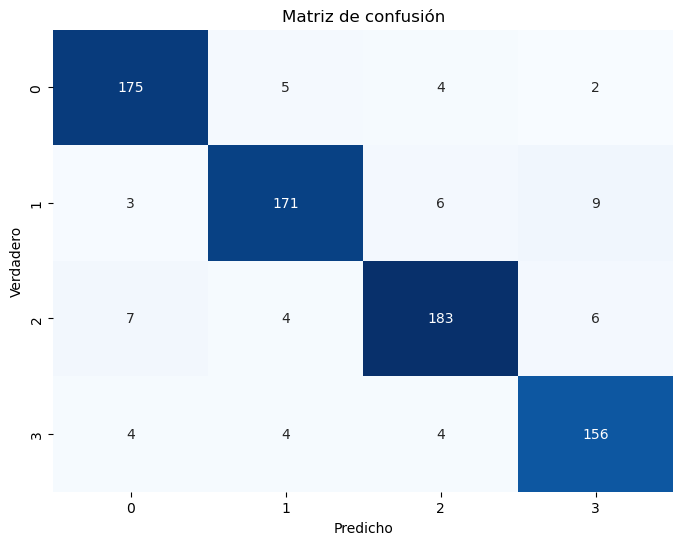

0.9219380888290714

In [26]:
acc_a4 = comprobar(y_val, preds)
acc_a4

## B1

In [27]:
ng_b1 = pd.read_pickle('20newsgroups_b1_embd_all.pkl')

ng_b1.head()

,id_documento,Grupo,Documento,Target,Embedding
1,60215,comp.sys.ibm.pc.hardware,brother market high performance video card sup...,3,"[-0.10741078733865704, 0.16764146474555933, 0...."
3,60771,comp.sys.ibm.pc.hardware,scsi card dma transfer disk scsi card dma tran...,3,"[0.2003467861471362, -0.015756689531148456, 0...."
4,51882,comp.sys.mac.hardware,jasmine drive understanding upsate driver mode...,4,"[0.0217188625036567, 0.13497258650679742, -0.0..."
6,52099,comp.sys.mac.hardware,dallastry tech support start,4,"[-0.03412666668494543, 0.12197666863600413, -0..."
21,68177,comp.windows.x,feature icccm specifie app set title oblige bo...,5,"[0.12941412054002285, 0.01326927974820137, -0...."


In [28]:
set(ng_b1['Target'])

{1, 2, 3, 4, 5}

In [29]:
y_encoded = [one_hot_encoding(target-1, 5) for target in ng_b1.iloc[:,3]]

In [30]:
ng_b1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 1 to 18264
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  4748 non-null   int64 
 1   Grupo         4748 non-null   object
 2   Documento     4748 non-null   object
 3   Target        4748 non-null   int64 
 4   Embedding     4748 non-null   object
dtypes: int64(2), object(3)
memory usage: 222.6+ KB


In [31]:
X, y = ng_b1['Embedding'].values, y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [38]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_b1, resultados = grid_search(X_train, y_train, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
30/30 [==============================] - 0s 2ms/step - loss: 0.8646 - accuracy: 0.6944
69.06297355890274
Modelo con [64, 10], 80, 200
30/30 [==============================] - 0s 2ms/step - loss: 0.8847 - accuracy: 0.6881
68.66779327392578
Modelo con [64, 10], 150, 100
30/30 [==============================] - 0s 2ms/step - loss: 0.8582 - accuracy: 0.6913
68.56233775615692
Modelo con [64, 10], 150, 200
30/30 [==============================] - 0s 1ms/step - loss: 0.8820 - accuracy: 0.6965
69.19485777616501
Modelo con 100, 80, 100
30/30 [==============================] - 0s 2ms/step - loss: 0.8700 - accuracy: 0.6913
69.01059448719025
Modelo con 100, 80, 200
30/30 [==============================] - 0s 2ms/step - loss: 0.8639 - accuracy: 0.6955
69.11560595035553
Modelo con 100, 150, 100
30/30 [==============================] - 0s 2ms/step - loss: 0.8583 - accuracy: 0.6976
69.58965063095093
Modelo con 100, 150, 200
30/30 [==============================] - 0s 1ms/s

In [39]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{(100, 150, 100): 0.6958965063095093,
 (100, 150, 200): 0.6935283839702606,
 ((64, 10), 150, 200): 0.6919485777616501,
 ((80, 20), 150, 100): 0.6914189606904984,
 (100, 80, 200): 0.6911560595035553,
 ((64, 10), 80, 100): 0.6906297355890274,
 (100, 80, 100): 0.6901059448719025,
 ((80, 20), 150, 200): 0.6895793527364731,
 ((80, 20), 80, 100): 0.6893128603696823,
 ((80, 20), 80, 200): 0.6872092485427856,
 ((64, 10), 80, 200): 0.6866779327392578,
 ((64, 10), 150, 100): 0.6856233775615692}

Nos quedamos con el modelo de 100, 150, 100

In [40]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_b1.model.fit(X_tensor, y_tensor)

119/119 [==============================] - 0s 2ms/step - loss: 0.7285 - accuracy: 0.7383


In [41]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_b1.predecir(X_val_tensor)

30/30 [==============================] - 0s 1ms/step


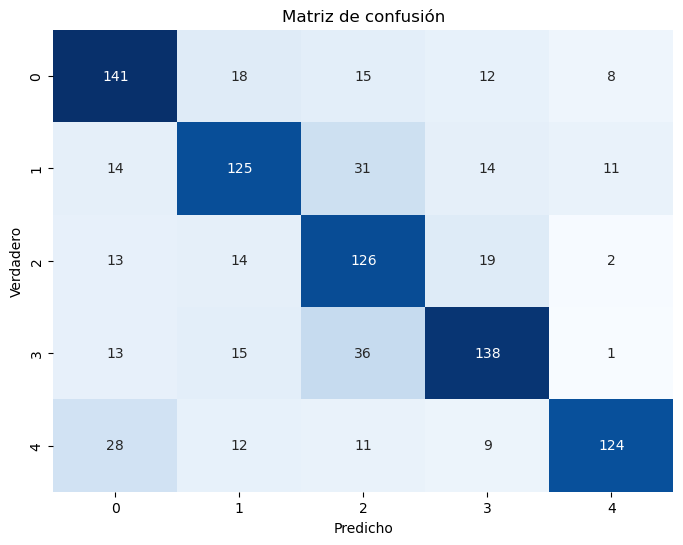

0.6884210526315789

In [42]:
acc_b1 = comprobar(y_val, preds)
acc_b1

## B2

In [43]:
ng_b2 = pd.read_pickle('20newsgroups_b2_embd_all.pkl')

ng_b2.head()

,id_documento,Grupo,Documento,Target,Embedding
0,54367,rec.sport.hockey,basher pen fan pretty confused lack kind post ...,10,"[-0.14216639818158, 0.091206159517169, -0.1639..."
7,53767,rec.sport.hockey,stuff delete solution problem canada yesterday...,10,"[-0.06843037190664486, 0.1768383335176052, -0...."
8,54033,rec.sport.hockey,yeah price good bruin sabre telecast wow good ...,10,"[-0.20051928583000386, 0.05742098328274941, -0..."
19,105204,rec.motorcycles,argue gyroscope throughly understand edthe tec...,8,"[0.009954410046339035, 0.12789846948238418, -0..."
20,103698,rec.autos,buy chevy gmc size pickup extended cab opinion...,7,"[0.030914567030966282, 0.26029603904113174, -0..."


In [44]:
set(ng_b2['Target'])

{7, 8, 9, 10}

In [45]:
y_encoded = [one_hot_encoding(target-7, 4) for target in ng_b2.iloc[:,3]]

In [46]:
X, y = ng_b2['Embedding'].values, y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [47]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_b2, resultados = grid_search(X_train, y_train, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4017 - accuracy: 0.8609
85.82677245140076
Modelo con [64, 10], 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8740
86.51574850082397
Modelo con [64, 10], 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.8701
86.22047305107117
Modelo con [64, 10], 150, 200
24/24 [==============================] - 0s 1ms/step - loss: 0.3913 - accuracy: 0.8688
86.31889820098877
Modelo con 100, 80, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.3803 - accuracy: 0.8727
86.64698153734207
Modelo con 100, 80, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.3877 - accuracy: 0.8688
86.87664270401001
Modelo con 100, 150, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8714
86.84383183717728
Modelo con 100, 150, 200
24/24 [==============================] - 0s 1ms/s

In [48]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{((80, 20), 150, 200): 0.8697506636381149,
 (100, 80, 200): 0.8687664270401001,
 (100, 150, 100): 0.8684383183717728,
 ((80, 20), 80, 100): 0.8674540668725967,
 ((80, 20), 80, 200): 0.8674540668725967,
 (100, 150, 200): 0.8671259880065918,
 (100, 80, 100): 0.8664698153734207,
 ((64, 10), 80, 200): 0.8651574850082397,
 ((64, 10), 150, 200): 0.8631889820098877,
 ((64, 10), 150, 100): 0.8622047305107117,
 ((80, 20), 150, 100): 0.8618766516447067,
 ((64, 10), 80, 100): 0.8582677245140076}

Nos quedamos con el modelo de 100, 150, 100

In [58]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_b2.model.fit(X_tensor, y_tensor)

96/96 [==============================] - 0s 3ms/step - loss: 0.1610 - accuracy: 0.9472


In [59]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_b2.predecir(X_val_tensor)

24/24 [==============================] - 0s 3ms/step


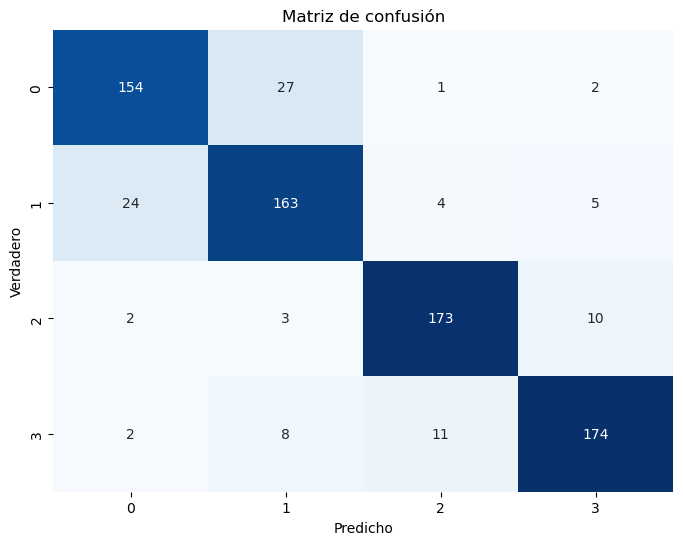

0.8702490170380078

In [60]:
acc_b2 = comprobar(y_val, preds)
acc_b2

## B3

In [61]:
ng_b3 = pd.read_pickle('20newsgroups_b3_embd_all.pkl')

ng_b3.head()

,id_documento,Grupo,Documento,Target,Embedding
5,54198,sci.electronics,high school work lab assistant bunch experimen...,12,"[-0.07230230656503409, 0.11754417311400175, -0..."
11,15596,sci.crypt,history untrustworthy behavoirsic,11,"[-0.22224999219179153, -0.34587499499320984, 0..."
13,59022,sci.med,kirlian imaging faq sciskeptic nice write supp...,13,"[-0.02201554331589829, 0.2004741860384291, 0.0..."
16,53899,sci.electronics,reply appeal info drive rpm modify bbc compute...,12,"[0.06011503435272191, 0.2880721700244716, 0.02..."
17,54203,sci.electronics,year ago victim squirted fair model teletype t...,12,"[0.011174500396009535, 0.07134094873617869, -0..."


In [62]:
set(ng_b3['Target'])

{11, 12, 13, 14}

In [63]:
y_encoded = [one_hot_encoding(target-11, 4) for target in ng_b3.iloc[:,3]]

In [64]:
X, y = ng_b3['Embedding'].values, y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [65]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_b3, resultados = grid_search(X_train, y_train, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.8549
86.73202693462372
Modelo con [64, 10], 80, 200
24/24 [==============================] - 0s 1ms/step - loss: 0.4242 - accuracy: 0.8641
87.38562166690826
Modelo con [64, 10], 150, 100
24/24 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.8458
87.32026219367981
Modelo con [64, 10], 150, 200
24/24 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.8471
87.41830140352249
Modelo con 100, 80, 100
24/24 [==============================] - 0s 2ms/step - loss: 0.4277 - accuracy: 0.8562
87.45098114013672
Modelo con 100, 80, 200
24/24 [==============================] - 0s 1ms/step - loss: 0.4249 - accuracy: 0.8549
87.1895432472229
Modelo con 100, 150, 100
24/24 [==============================] - 0s 3ms/step - loss: 0.4233 - accuracy: 0.8588
87.41830140352249
Modelo con 100, 150, 200
24/24 [==============================] - 0s 2ms/st

In [66]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{((80, 20), 150, 100): 0.8781045824289322,
 ((80, 20), 150, 200): 0.875490203499794,
 (100, 150, 200): 0.8751634061336517,
 ((80, 20), 80, 100): 0.8751634061336517,
 (100, 80, 100): 0.8745098114013672,
 ((64, 10), 150, 200): 0.8741830140352249,
 (100, 150, 100): 0.8741830140352249,
 ((64, 10), 80, 200): 0.8738562166690826,
 ((64, 10), 150, 100): 0.8732026219367981,
 (100, 80, 200): 0.871895432472229,
 ((80, 20), 80, 200): 0.8676470667123795,
 ((64, 10), 80, 100): 0.8673202693462372}

Nos quedamos con el modelo de 100, 150, 100

In [79]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_b3.model.fit(X_tensor, y_tensor)

96/96 [==============================] - 0s 4ms/step - loss: 0.1619 - accuracy: 0.9467


In [80]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_b3.predecir(X_val_tensor)

24/24 [==============================] - 0s 3ms/step


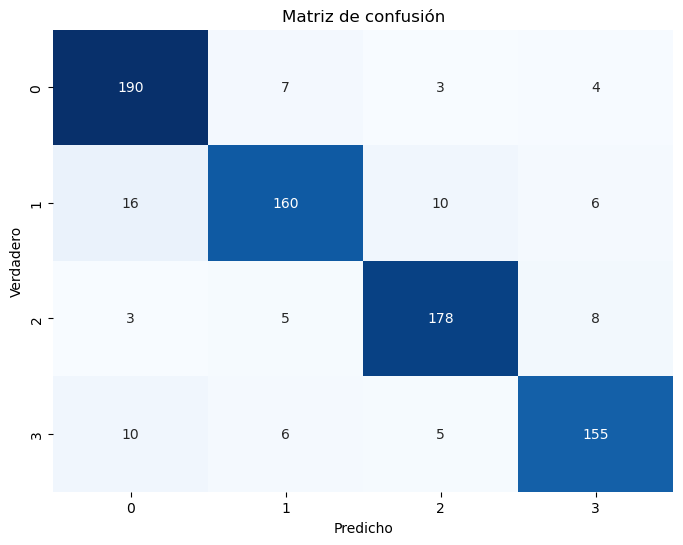

0.891644908616188

In [81]:
acc_b3 = comprobar(y_val, preds)
acc_b3

## B4

In [82]:
ng_b4 = pd.read_pickle('20newsgroups_b4_embd_all.pkl')

ng_b4.head()

,id_documento,Grupo,Documento,Target,Embedding
2,76120,talk.politics.mideast,finally dream mediterranean area great year ho...,17,"[-0.22868308251178482, 0.027676702670116977, 0..."
9,84236,talk.religion.misc,christian divinity jesus safe jesus christian ...,19,"[-0.1727562840417798, -0.11107386314663394, 0...."
10,83609,talk.religion.misc,blood lamb hard task culture animal blood sacr...,19,"[-0.11223129451494007, 0.08317440534558367, 0...."
12,83506,talk.religion.misc,wilt law honestly word sin restriction kid man...,19,"[-0.01871928367376185, 0.06832325235652541, -0..."
15,76476,talk.politics.mideast,report turkey eyes regional role ankara turkey...,17,"[-0.10081068279736853, -0.05010895942278365, 0..."


In [83]:
set(ng_b4['Target'])

{16, 17, 18, 19}

In [84]:
y_encoded = [one_hot_encoding(target-16, 4) for target in ng_b4.iloc[:,3]]

In [85]:
X, y = ng_b4['Embedding'].values, y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [86]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_b4, resultados = grid_search(X_train, y_train, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
20/20 [==============================] - 0s 3ms/step - loss: 0.6774 - accuracy: 0.7512
74.64342266321182
Modelo con [64, 10], 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.7464
74.84152168035507
Modelo con [64, 10], 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.6792 - accuracy: 0.7464
75.4358172416687
Modelo con [64, 10], 150, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.7417
74.80190098285675
Modelo con 100, 80, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.7417
74.24722760915756
Modelo con 100, 80, 200
20/20 [==============================] - 0s 2ms/step - loss: 0.6792 - accuracy: 0.7464
74.52456504106522
Modelo con 100, 150, 100
20/20 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.7480
74.9603807926178
Modelo con 100, 150, 200
20/20 [==============================] - 0s 2ms/ste

In [87]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{((64, 10), 150, 100): 0.754358172416687,
 ((80, 20), 150, 100): 0.7543581575155258,
 ((80, 20), 80, 200): 0.7527733743190765,
 (100, 150, 100): 0.749603807926178,
 ((80, 20), 150, 200): 0.749207615852356,
 (100, 150, 200): 0.7488114088773727,
 ((64, 10), 80, 200): 0.7484152168035507,
 ((64, 10), 150, 200): 0.7480190098285675,
 ((80, 20), 80, 100): 0.7472266107797623,
 ((64, 10), 80, 100): 0.7464342266321182,
 (100, 80, 200): 0.7452456504106522,
 (100, 80, 100): 0.7424722760915756}

Nos quedamos con el modelo de 100, 150, 200

In [94]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_b4.model.fit(X_tensor, y_tensor)

79/79 [==============================] - 0s 4ms/step - loss: 0.4611 - accuracy: 0.8352


In [95]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_b4.predecir(X_val_tensor)

20/20 [==============================] - 0s 4ms/step


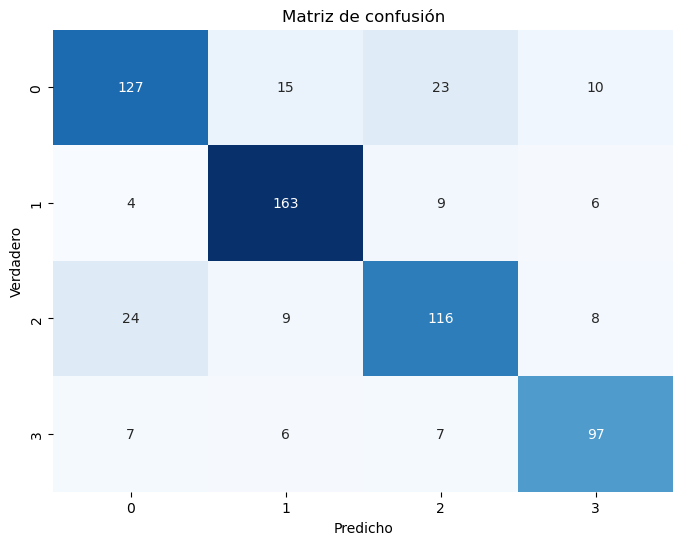

0.7971473851030111

In [96]:
acc_b4 = comprobar(y_val, preds)
acc_b4

## AB

In [97]:
ng_ab = pd.concat([ng_b2, ng_b3], axis=0)

ng_ab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7637 entries, 0 to 18262
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id_documento  7637 non-null   int64 
 1   Grupo         7637 non-null   object
 2   Documento     7637 non-null   object
 3   Target        7637 non-null   int64 
 4   Embedding     7637 non-null   object
dtypes: int64(2), object(3)
memory usage: 358.0+ KB


In [98]:
set(ng_ab['Target'])

{7, 8, 9, 10, 11, 12, 13, 14}

In [99]:
y_encoded = [one_hot_encoding(target-7, 8) for target in ng_ab.iloc[:,3]]

In [100]:
X, y = ng_ab['Embedding'].values, y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [128]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_ab, resultados = grid_search(X_train, y_train, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.5626 - accuracy: 0.8199
82.61571079492569
Modelo con [64, 10], 80, 200
48/48 [==============================] - 0s 2ms/step - loss: 0.5498 - accuracy: 0.8284
82.59927481412888
Modelo con [64, 10], 150, 100
48/48 [==============================] - 0s 1ms/step - loss: 0.5610 - accuracy: 0.8258
82.76312053203583
Modelo con [64, 10], 150, 200
48/48 [==============================] - 0s 3ms/step - loss: 0.5749 - accuracy: 0.8291
82.5829342007637
Modelo con 100, 80, 100
48/48 [==============================] - 0s 2ms/step - loss: 0.5324 - accuracy: 0.8382
83.61430317163467
Modelo con 100, 80, 200
48/48 [==============================] - 0s 1ms/step - loss: 0.5328 - accuracy: 0.8428
83.72891694307327
Modelo con 100, 150, 100
48/48 [==============================] - 0s 3ms/step - loss: 0.5251 - accuracy: 0.8435
83.67984592914581
Modelo con 100, 150, 200
48/48 [==============================] - 0s 2ms/st

In [129]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{(100, 80, 200): 0.8372891694307327,
 (100, 150, 100): 0.8367984592914581,
 ((80, 20), 80, 200): 0.8367980122566223,
 ((80, 20), 150, 100): 0.8363068550825119,
 (100, 80, 100): 0.8361430317163467,
 (100, 150, 200): 0.8356520980596542,
 ((80, 20), 150, 200): 0.8330331146717072,
 ((80, 20), 80, 100): 0.8323784470558167,
 ((64, 10), 150, 100): 0.8276312053203583,
 ((64, 10), 80, 100): 0.8261571079492569,
 ((64, 10), 80, 200): 0.8259927481412888,
 ((64, 10), 150, 200): 0.825829342007637}

Nos quedamos con el modelo de 100, 150, 200

In [169]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_ab.model.fit(X_tensor, y_tensor)

191/191 [==============================] - 1s 4ms/step - loss: 0.1380 - accuracy: 0.9632


In [170]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_ab.predecir(X_val_tensor)

48/48 [==============================] - 0s 2ms/step


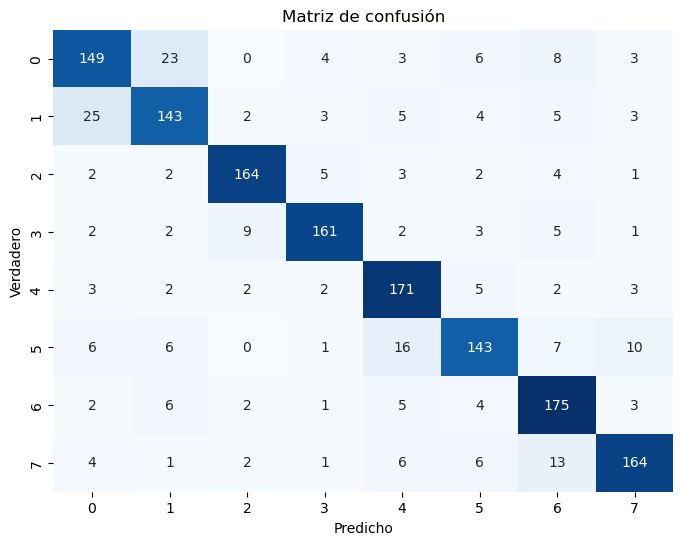

0.831151832460733

In [171]:
acc_ab = comprobar(y_val, preds)
acc_ab

#### Muestra total

In [126]:
ng_20 = pd.read_pickle('20newsgroups_embd_all.pkl')

ng_20.head()

,id_documento,Grupo,Documento,Target,Embedding
0,54367,rec.sport.hockey,basher pen fan pretty confused lack kind post ...,10,"[-0.14216639818158, 0.091206159517169, -0.1639..."
1,60215,comp.sys.ibm.pc.hardware,brother market high performance video card sup...,3,"[-0.10741078733865704, 0.16764146474555933, 0...."
2,76120,talk.politics.mideast,finally dream mediterranean area great year ho...,17,"[-0.22868308251178482, 0.027676702670116977, 0..."
3,60771,comp.sys.ibm.pc.hardware,scsi card dma transfer disk scsi card dma tran...,3,"[0.2003467861471362, -0.015756689531148456, 0...."
4,51882,comp.sys.mac.hardware,jasmine drive understanding upsate driver mode...,4,"[0.0217188625036567, 0.13497258650679742, -0.0..."


In [127]:
y_encoded = [one_hot_encoding(target-1, 20) for target in ng_20.iloc[:,3]]

In [78]:
X, y = ng_20['Embedding'].values, y_encoded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)

In [79]:
hidden_units = [[64, 10], 100, [80, 20]]
epochs=[80, 150]
batch_sizes=[100, 200]

modelo_20, resultados = grid_search(X, y, hidden_units, epochs, batch_sizes)

Modelo con [64, 10], 80, 100
143/143 [==============================] - 0s 1ms/step - loss: 1.1557 - accuracy: 0.6654
66.29389375448227
Modelo con [64, 10], 80, 200
143/143 [==============================] - 0s 1ms/step - loss: 1.1500 - accuracy: 0.6648
66.11854881048203
Modelo con [64, 10], 150, 100
143/143 [==============================] - 0s 1ms/step - loss: 1.1715 - accuracy: 0.6556
66.03087484836578
Modelo con [64, 10], 150, 200
143/143 [==============================] - 0s 2ms/step - loss: 1.1820 - accuracy: 0.6496
65.86641520261765
Modelo con 100, 80, 100
143/143 [==============================] - 0s 1ms/step - loss: 1.0546 - accuracy: 0.6917
69.70837116241455
Modelo con 100, 80, 200
143/143 [==============================] - 0s 2ms/step - loss: 1.0502 - accuracy: 0.6911
69.76318061351776
Modelo con 100, 150, 100
143/143 [==============================] - 0s 1ms/step - loss: 1.0515 - accuracy: 0.6900
69.58777457475662
Modelo con 100, 150, 200
143/143 [==========================

In [80]:
dict(sorted(resultados.items(), key=lambda item: item[1], reverse=True))

{(100, 80, 200): 0.6976318061351776,
 (100, 80, 100): 0.6970837116241455,
 (100, 150, 200): 0.6969194710254669,
 (100, 150, 100): 0.6958777457475662,
 ((80, 20), 150, 100): 0.6837656199932098,
 ((80, 20), 80, 100): 0.6826694905757904,
 ((80, 20), 80, 200): 0.681847020983696,
 ((80, 20), 150, 200): 0.6791068315505981,
 ((64, 10), 80, 100): 0.6629389375448227,
 ((64, 10), 80, 200): 0.6611854881048203,
 ((64, 10), 150, 100): 0.6603087484836578,
 ((64, 10), 150, 200): 0.6586641520261765}

Nos quedamos con el modelo de 100, 150, 200

In [81]:
X_tensor, y_tensor = np.asarray([tf.constant(arr) for arr in X_train]), np.asarray([tf.constant(arr) for arr in y_train])

modelo_20.model.fit(X_tensor, y_tensor)

457/457 [==============================] - 1s 2ms/step - loss: 0.9447 - accuracy: 0.7114


In [84]:
X_val_tensor = np.asarray([tf.constant(arr) for arr in X_val])

preds = modelo_20.predecir(X_val_tensor)

115/115 [==============================] - 0s 2ms/step


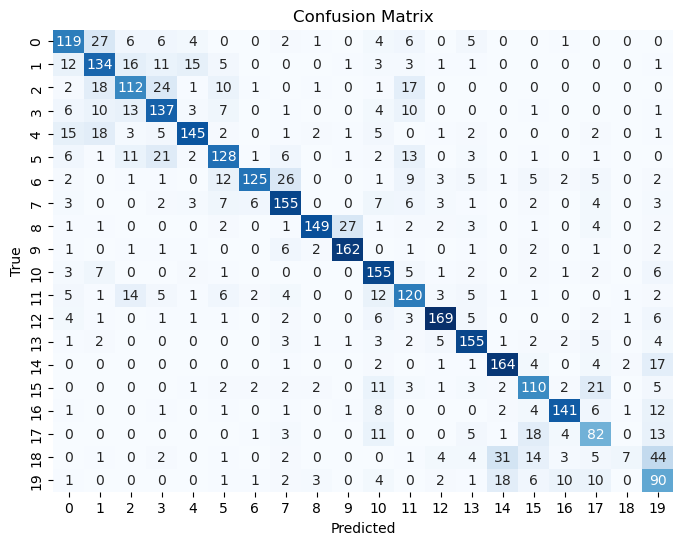

0.7010958904109589

In [85]:
acc_20 = comprobar(y_val, preds)
acc_20

# Comportamiento vectorial

In [130]:
from sklearn import svm

clf = svm.SVC(kernel='linear')

clf.fit(X_train, y_train)

preds = clf.predict(X_val)

# Evaluación del modelo
accuracy = accuracy_score(y_val, preds)
print("Precisión del modelo SVM:", accuracy)


ValueError: setting an array element with a sequence.